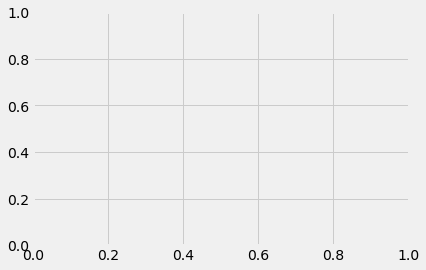

In [15]:
import numpy as np
import pandas as pd
from numba import vectorize,jit
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
style.use('fivethirtyeight')
erros = []
epoca = 0
df = pd.read_csv('mnist_train.csv')
outputAwnser = {'0':[1,0,0,0,0,0,0,0,0,0], '1':[0,2,0,0,0,0,0,0,0,0],
                '2':[0,0,1,0,0,0,0,0,0,0], '3':[0,0,0,1,0,0,0,0,0,0], '4':[0,0,0,0,1,0,0,0,0,0], 
                '5':[0,0,0,0,0,1,0,0,0,0], '6':[0,0,0,0,0,0,1,0,0,0], '7':[0,0,0,0,0,0,0,1,0,0], 
                '8':[0,0,0,0,0,0,0,0,1,0], '9':[0,0,0,0,0,0,0,0,0,1] }

n_inputs = 784
hidenLayerSize = 100
outputSize = 10

def saveGraph():
    global ax1
    global erros
    epochList = np.arange(epoca)
    ax1.clear()
    ax1.plot(epochList,erros)
    plt.savefig(r"c:\Users\Danilo\Trabalho Max\epocas\epoca{0}.png".format(epoca))

vWeigths = np.random.uniform(-1.00,1.00,(n_inputs,hidenLayerSize))
wWeigths = np.random.uniform(-1,1,(hidenLayerSize,outputSize))
vWeigths = vWeigths.round(3).astype(np.float32)
wWeigths = wWeigths.round(3).astype(np.float32)
taxaA = np.float32(0.2)


def activateFunc(x, boolean):
    if (boolean):
        return (1/(1+(np.exp(-x))))
    else: 
        return (2/1+ np.exp(-x)) -1

@vectorize(['float32(float32, float32)'], target='cuda')
def multiplyArrays(a, b):
    return a * b

def alllHiddenLayers(xInput, matrix):
    hiddenValues = np.zeros(np.size(matrix,axis=1),np.float32)
    xInput = np.array(xInput, np.float32)
    for j in range(np.size(matrix,axis=1)):
        hiddenValues[j] = (np.sum(multiplyArrays(xInput,np.array(matrix[:,j],np.float32))))
    return hiddenValues


def calcDelta(arr):
    deltas = np.zeros(len(arr),np.float32)
    for i in range(len(arr)):
        deltas[i] = activateFunc(arr[i], True)
    return deltas
  
def derivada(Y_ink, boolean):
    if (boolean):
        return Y_ink * (1 - Y_ink) 
    else:  
        return 0.5 * (1 + Y_ink) * (1 - Y_ink)

def compareOutWithExpected(expected, out):
    for i in range(len(out)):
        if (expected[i] != out[i]):
            return False
    return True

def calculateDeltaK(tK, yK, inputList):
    deltaK = np.zeros(len(inputList), np.float32)
    for i in range(len(inputList)):
        deltaK[i] = (tK[i] - yK[i]) * derivada(inputList[i],True)
    return deltaK


def calculaDeltaW(deltaK, zOut):
    deltaW = np.zeros([hidenLayerSize, outputSize], np.float32)
    for j in range(hidenLayerSize):
        for k in range(outputSize):
            deltaW[j][k] = taxaA * deltaK[k] * zOut[j]
    return deltaW


def sumDeltaInJ(deltaK, matrix):
    Dj_in = np.zeros(hidenLayerSize, np.float32)
    for k in range(outputSize):
        for j in range(hidenLayerSize):
            Dj_in[j] += deltaK[k] * wWeigths[j][k]           
    return Dj_in
        

def calculateDeltaJ(Dj_in, z_in):
    deltaJ = np.zeros(hidenLayerSize, np.float32)
    for j in range(hidenLayerSize):
        deltaJ[j] = Dj_in[j] * derivada(z_in[j], True)
    return deltaJ


def calculaDeltaV(a, deltaJ):
    deltaV = np.zeros([n_inputs, hidenLayerSize], np.float32)
    for i in range(n_inputs):
        for j in range(hidenLayerSize):
            deltaV[i][j] = taxaA * deltaJ[j] * a[i]
    return deltaV


def atualizaPesos(deltaW, deltaV):
    for j in range(hidenLayerSize):
        for k in range(outputSize):
            wWeigths[j][k] += deltaW[j][k]
    
    for i in range(n_inputs):
        for j in range(hidenLayerSize):
            vWeigths[i][j] += deltaV[i][j]

def backpropagation(a, z_in, zOut, target, netOutput, y_in):
    deltaK = calculateDeltaK(target, netOutput, y_in).round(3).astype(np.float32)
    deltaW = calculaDeltaW(deltaK, zOut).round(3).astype(np.float32)
    Dj_in = sumDeltaInJ(deltaK, wWeigths).round(3).astype(np.float32)
    deltaJ = calculateDeltaJ(Dj_in, z_in).round(3).astype(np.float32)
    deltaV = calculaDeltaV(a, deltaJ).round(3).astype(np.float32)
    atualizaPesos(deltaW, deltaV)
    
    
def atualizaGrafico():
    epochList = np.arange(epoca)
    print(erros)
    print(epochList)
    ax1.clear()
    ax1.plot(erros, epochList)
    
def propagation(training, epoch):
    global epoca
    global erros
    global graph 
    
    for ep in range(epoch):
        global err
        err = 0
        i = 0
        for row in df.itertuples(index=False):
            a = list(row)
            expected = a.pop(0)
            target = outputAwnser[str(expected)]
            z_in = alllHiddenLayers(a,vWeigths).round(3).astype(np.float32)
            zOut = calcDelta(z_in).round(3).astype(np.float32)
            y_in = alllHiddenLayers(zOut, wWeigths).round(3).astype(np.float32)
            netOutput = calcDelta(y_in).round(3).astype(np.float32)
            i+=1
            if training:
                acertou = compareOutWithExpected(target, netOutput)
                if (not acertou):
                    err += 1
                    backpropagation(a,z_in, zOut, target, netOutput, y_in)
            print(f'ja foram {i} linhas da epoca {epoca}')
            print(f'Pesos W:  {wWeigths}')
            print(f'Pesos W:  {wWeigths}')
            print(f'erros: {err}')
            saveGraph()
            break
        erros.append(err)
        epoca += 1
        saveGraph()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
#propagation(True, 100)

In [7]:
#a,target,z_in,zOut,y_in,netOutput = [],[],[],[],[],[]
#deltaK = np.zeros(len(y_in), np.float32)
#deltaW = np.zeros([hidenLayerSize, outputSize], np.float32)
#Dj_in = np.zeros(hidenLayerSize, np.float32)
#deltaJ = np.zeros(hidenLayerSize, np.float32)
#deltaV = np.zeros([n_inputs, hidenLayerSize], np.float32)


In [16]:

propagation(True, 1)

ja foram 1 linhas da epoca 0
Pesos W:  [[-4.49000001e-01  1.11000001e-01 -3.93999994e-01 -8.16999972e-01
  -7.82999992e-01 -1.03000000e-01 -1.34000003e-01  7.42999971e-01
   1.33000001e-01  6.29999995e-01]
 [ 4.46000010e-01 -1.36999995e-01  4.14000005e-01  1.71000004e-01
   8.92000020e-01  8.10000002e-02  5.70999980e-01  6.29999995e-01
   6.02999985e-01 -1.94000006e-01]
 [ 2.87999988e-01 -2.38999993e-01 -7.03999996e-01  1.38999999e-01
  -8.08000028e-01 -4.02999997e-01 -9.38000023e-01 -7.12000012e-01
  -1.26000002e-01 -9.17999983e-01]
 [ 4.52099991e+00  9.35000002e-01  3.31000000e-01 -6.66999996e-01
   1.72899997e+00 -1.80999994e-01 -7.31000006e-01 -6.25999987e-01
  -1.30000114e-02  1.15920000e+01]
 [ 4.59100008e+00 -4.14000034e-01  5.91000021e-01  8.79999995e-02
   2.79500008e+00 -7.03000009e-01 -4.32000011e-01  7.16000021e-01
   1.47600007e+00  1.12800007e+01]
 [-6.35999978e-01  4.88999993e-01  8.74000013e-01  5.45000017e-01
   9.70000029e-02  7.30000019e-01 -5.79999983e-02  4.0400001

<Figure size 432x288 with 0 Axes>

In [31]:
wWeigths = wWeigths.round(2)

In [33]:
wWeigths = wWeigths.astype(np.float32)

In [36]:
wWeigths

array([[-0.346, -0.53 , -0.762,  0.899,  0.825,  0.451, -0.202, -0.95 ,
        -0.484, -0.656],
       [-0.652,  0.768,  0.184, -0.003, -0.464, -0.26 , -0.328,  0.642,
        -0.067, -0.225],
       [-0.347,  0.275, -0.949,  0.686, -0.641,  0.848,  0.216,  0.887,
        -0.458,  0.741],
       [ 0.071, -0.945, -0.004, -0.319,  0.891,  0.032,  0.974, -0.078,
         0.022, -0.554],
       [ 0.476,  0.894, -0.289, -0.901,  0.756, -0.716, -0.763, -0.209,
         0.923,  0.708],
       [-0.123, -0.307,  0.147,  0.237,  0.024,  0.822, -0.95 ,  0.739,
        -0.841, -0.807],
       [ 0.406,  0.108, -0.713,  0.824, -0.173,  0.182, -0.755,  0.44 ,
         0.603,  0.35 ],
       [ 0.519,  0.813, -0.889, -0.35 ,  0.759,  0.08 ,  0.322,  0.737,
        -0.232, -0.603],
       [ 0.08 ,  0.475,  0.736, -0.751, -0.222, -0.213,  0.438, -0.576,
        -0.711,  0.938],
       [-0.626, -0.398, -0.001,  0.023,  0.083,  0.499, -0.68 ,  0.302,
        -0.55 ,  0.92 ],
       [ 0.919,  0.301,  0.562